<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_10/text_classification_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Natural Language Processing Example - Sentiment Classification

IMDB Dataset is a dataset for binary sentiment classification (positive or negative reviews). It contains a set of 25,000 highly polar movie reviews for training and 25,000 for testing.

 - http://ai.stanford.edu/~amaas/data/sentiment/
 - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Based on: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter14_text-classification.ipynb


In [6]:
import os
os.environ["KERAS_BACKEND"] = "jax"



### Download and extract the zip file with the data

In [7]:
!rm -r aclImdb
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup



rm: cannot remove 'aclImdb': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  46.6M      0  0:00:01  0:00:01 --:--:-- 46.6M


In [8]:
import os, pathlib, shutil, random, keras

imdb_extract_dir = pathlib.Path("aclImdb")
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)


aclImdb/train/neg
aclImdb/train/pos
aclImdb/test/neg
aclImdb/test/pos


In [3]:
# observe some reviews: the file name ends with the actual grade
!cat aclImdb/train/pos/10014_8.txt


The Night Listener held my attention, with Robin Williams shining as a New York City radio host who becomes enamored with his friendship with a 14 year old boy (Rory Culkin) who is very ill. Williams has never met the boy in person, as they have only been in contact by talking on the telephone. However, Williams' ex-boyfriend (nice job from Bobby Cannavale) raises doubt about the boy, which prompts Williams to arrange a meeting with him in person. What follows makes a permanent impact on Williams in a way he does not expect. I will leave it at that. Toni Collette also stars.<br /><br />I enjoyed this film, with Toni Collette giving a memorable portrayal of Culkin's adoptive mother. Sandra Oh also starred as Williams' friend. The Night Listener is inspired by actual events, and it has a somber, almost creepy silence throughout. At times it is predictable, no thanks to some of the reviews I read before seeing the movie and just due to logic, but I liked it anyway. I enjoy Williams in rol

In [4]:
!cat aclImdb/train/neg/10024_3.txt

First lesson that some film makers (particularly those inspired by Hollywood) need to know - just 'style' does not sell. I guess Tashan when translated will mean style. Second, if you are hell bent on selling style, that does not spare you from having a decent story.<br /><br />Tashan has some story which could have sufficed with some better director. But it is not slick. For example, all three - Saif, Kareena and Akshay - are narrators at different points in the story. But this setup is not utilized to properly. There could have been a better mix and match of their narrations. Actions sequences are from the seventies.<br /><br />Cheoreography of the film is awful. I think Vaibhavi Merchant just sleep walked through this film. Vishal-Shekhar have put up a good score but it does not belong to this film. Why is there a sufi song (Dil Haara) in Tashan? Why is the cool Hinglish song (Dil Dance Maare) not on Anil Kapoor when he is the one who is English crazy? <br /><br />Akshay Kumar is th

## Prepare the data:
1. divide the train folder into two folders: train and val


In [9]:
import os, pathlib, shutil, random

# Create the directory with the validation data
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
test_dir = base_dir / "test"


os.makedirs(val_dir)
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)



In [6]:
for path in base_dir.glob("*/*"):
    if path.is_dir():
        print(path)

aclImdb/train/neg
aclImdb/train/pos
aclImdb/val/neg
aclImdb/val/pos
aclImdb/test/neg
aclImdb/test/pos


2. create the datasets from the directories

In [7]:
import keras

batch_size = 32

# Create the training, validation and testing data sets:
train_ds = keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    val_dir, batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## The bag of words approach - 1. Unigrams



### Preprocess the data
- Configure the TextVectorization layer to return bag-of-words
- Define the number of tokens to keep (skip the unimportant ones): choosing the 20,000 most important tokens is a reasonable choice.
- Note: Vectorization always run on the CPU (we set num_parallel calls).

In [ ]:
max_tokens = 20000
max_length = 600      # Maximum length of each sequence (longer sequences will be truncated)


text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot", # "tf_idf" "counts"
    split = "whitespace"
)

# create vocabulary based on the daataset
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

bow_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)
bow_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)
bow_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)

for inputs, targets in bow_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1 1 1 ... 0 0 0], shape=(20000,), dtype=int64)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
# 20 000 input features, batch size 32
x, y = next(bow_train_ds.as_numpy_iterator())
print(x.shape, y.shape)


(32, 20000) (32,)


In [ ]:
# observe the vocabulary
text_vectorization.get_vocabulary()[0:12]

['[UNK]',
 np.str_('the'),
 np.str_('and'),
 np.str_('a'),
 np.str_('of'),
 np.str_('to'),
 np.str_('is'),
 np.str_('in'),
 np.str_('it'),
 np.str_('i'),
 np.str_('this'),
 np.str_('that')]

In [ ]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('after'),
 np.str_('characters'),
 np.str_('think'),
 np.str_('watch'),
 np.str_('many'),
 np.str_('two'),
 np.str_('seen'),
 np.str_('being')]

### Define a MLP (or a simple linear classifier)

In [ ]:
from keras import layers

def get_mlp_model(max_tokens=20000, hidden_dim=None):
    inputs = keras.Input(shape=(max_tokens,))
    if hidden_dim is not None: # one hidden layer
        x = layers.Dense(hidden_dim, activation="relu")(inputs)
        x = layers.Dropout(0.5)(x)
    else: # simple linear classifier (no hidden layer)
        x = inputs
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_mlp_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# plot the training progress:
def plot_history(history):
    history_dict = history.history
    print(history_dict.keys())

    from matplotlib import pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [17]:
import pandas as pd
results_df = pd.DataFrame()

### Train a MLP model on bag of words (unigrams)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7811 - loss: 0.5449 - val_accuracy: 0.8842 - val_loss: 0.3496
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9033 - loss: 0.3100 - val_accuracy: 0.8960 - val_loss: 0.2947
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9234 - loss: 0.2458 - val_accuracy: 0.9006 - val_loss: 0.2716
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9369 - loss: 0.2084 - val_accuracy: 0.9032 - val_loss: 0.2596
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9483 - loss: 0.1818 - val_accuracy: 0.9036 - val_loss: 0.2528
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9572 - loss: 0.1612 - val_accuracy: 0.9018 - val_loss: 0.2491
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9645 - loss: 0.1443 - val_accuracy: 0.9030 - val_loss: 0.2473
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9694 - loss: 0.1302 - val_accuracy: 0

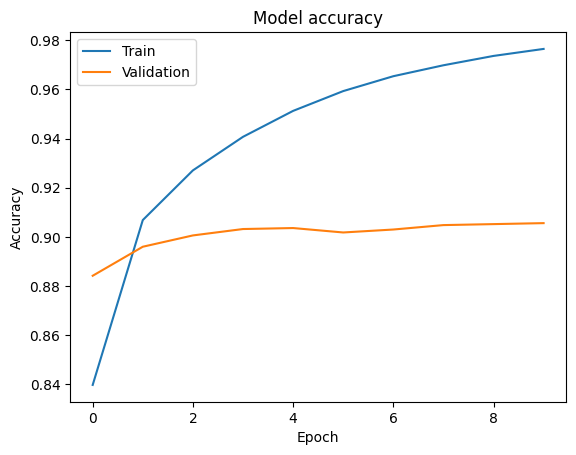

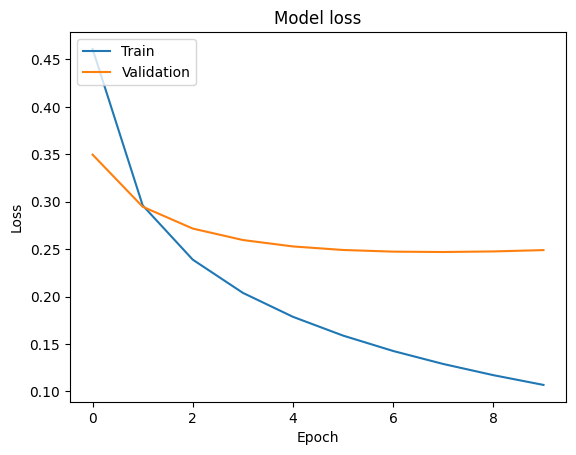

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9748 - loss: 0.1169
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9046 - loss: 0.2478
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8854 - loss: 0.2816
Train acc: 0.977
Val acc: 0.905
Test acc: 0.884


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.9766,0.9048,0.88432,<built-in function max>,30.892226


In [ ]:
hidden_dim = None
max_epochs = 10
model_name = "BOW_MLP.keras"

###############################################
# Define the model architecture:
model = get_mlp_model(max_tokens, hidden_dim)
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(bow_train_ds.cache(),
          validation_data=bow_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(bow_train_ds)
val_loss, val_acc = model.evaluate(bow_val_ds)
test_loss, test_acc = model.evaluate(bow_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
results_df.to_csv("results.csv", index=False)
results_df

### Apply the model to new texts

In [ ]:
import keras
import tensorflow as tf

base_model = keras.models.load_model("models/BOW_MLP.keras")

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

text 0: 27.99 percent positive
text 1: 56.41 percent positive
text 2: 86.08 percent positive
text 3: 67.17 percent positive
text 4: 60.30 percent positive


## The bag of words approach - 2. Bigrams

### Preprocess the data
- configure the TextVectorization layer to return binary encoded bigrams

In [ ]:
max_tokens = 30000
text_vectorization = layers.TextVectorization(
    ngrams=2,                # change here
    max_tokens=max_tokens,
    output_mode= "multi_hot", # you can try also: "count", "multi_hot", "tf_idf"
)

text_vectorization.adapt(text_only_train_ds)
bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)
bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)
bigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)

for inputs, targets in bigram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 30000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1 1 1 ... 0 0 0], shape=(30000,), dtype=int64)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
x, y = next(bigram_train_ds.as_numpy_iterator())
print(x.shape, y.shape)

(32, 30000) (32,)


In [ ]:
text_vectorization.get_vocabulary()[0:12]

['[UNK]',
 np.str_('the'),
 np.str_('and'),
 np.str_('a'),
 np.str_('of'),
 np.str_('to'),
 np.str_('is'),
 np.str_('in'),
 np.str_('it'),
 np.str_('i'),
 np.str_('this'),
 np.str_('that')]

In [ ]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('bad'),
 np.str_('most'),
 np.str_('him'),
 np.str_('dont'),
 np.str_('it was'),
 np.str_('one of'),
 np.str_('made'),
 np.str_('then')]

### Train a MLP model on binary encoded bigrams

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        30,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,001 (117.19 KB)

 Trainable params: 30,001 (117.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8140 - loss: 0.4921 - val_accuracy: 0.9018 - val_loss: 0.2931
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9314 - loss: 0.2375 - val_accuracy: 0.9072 - val_loss: 0.2539
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9542 - loss: 0.1735 - val_accuracy: 0.9106 - val_loss: 0.2396
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9700 - loss: 0.1347 - val_accuracy: 0.9112 - val_loss: 0.2334
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9809 - loss: 0.1076 - val_accuracy: 0.9116 - val_loss: 0.2314
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9886 - loss: 0.0873 - val_accuracy: 0.9110 - val_loss: 0.2316
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9927 - loss: 0.0716 - val_accuracy: 0.9092 - val_loss: 0.2333
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9953 - loss: 0.0590 - val_accuracy: 

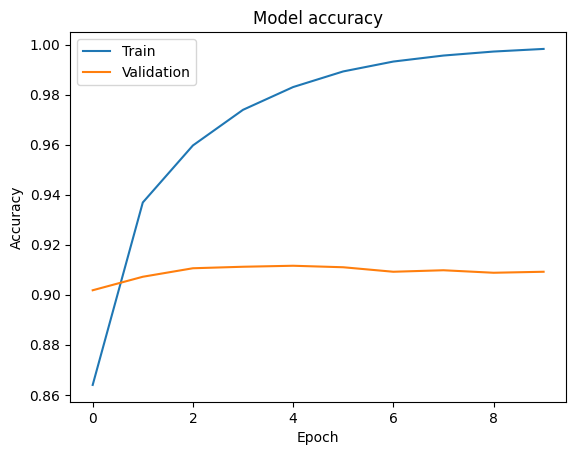

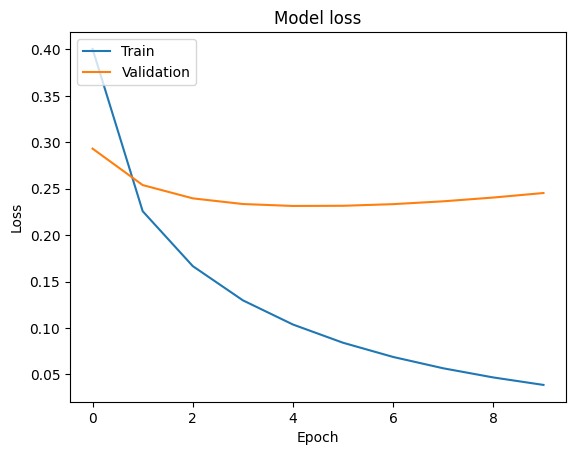

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9895 - loss: 0.0862
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9024 - loss: 0.2402
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9035 - loss: 0.2469
Train acc: 0.991
Val acc: 0.912
Test acc: 0.902


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.97660,0.9048,0.88432,<built-in function max>,30.892226
1,bigram_MLP,"30000 tokens, None",0.082274,0.231371,0.250554,0.99115,0.9116,0.90196,<built-in function max>,41.305188


In [ ]:
hidden_dim = None
max_epochs = 10
model_name = "bigram_MLP.keras"

###############################################
# Define the model architecture:
model = get_mlp_model(max_tokens, hidden_dim)
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(bigram_train_ds.cache(),
          validation_data=bigram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(bigram_train_ds)
val_loss, val_acc = model.evaluate(bigram_val_ds)
test_loss, test_acc = model.evaluate(bigram_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

In [ ]:
# remove the second row from df:
#results_df = results_df.drop(1)
#results_df

In [ ]:
# remove big datasets from memory

del bigram_train_ds
del bigram_val_ds
del bigram_test_ds


### Apply the model to new texts

In [ ]:
import keras
import tensorflow as tf

base_model = keras.models.load_model("models/bigram_MLP.keras")

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

text 0: 20.32 percent positive
text 1: 44.87 percent positive
text 2: 90.80 percent positive
text 3: 78.04 percent positive
text 4: 65.94 percent positive


__Observation:__ better results than for unigrams

## Sequential model on one-hot vectors
- all sequences are truncated or padded to the length 600
- we use the biridectional LSTM model
- the training is very slow and unefficient

In [8]:

from keras import layers

max_length = 600      # Maximum length of each sequence (longer sequences will be truncated)
max_tokens = 20000    # Number of (most important) tokens

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",                 # Convert text to sequences of integer indices
    output_sequence_length=max_length, # Ensure sequences have the given fixed length
)

# This step analyzes the dataset to create a vocabulary based on the most frequent tokens
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

# Observe the data:
for inputs, targets in int_train_ds:
      print("inputs.shape:", inputs.shape)
      print("inputs.dtype:", inputs.dtype)
      print("targets.shape:", targets.shape)
      print("targets.dtype:", targets.dtype)
      print("inputs:", inputs)
      print("targets:", targets)
      break



inputs.shape: (32, 600)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs: tf.Tensor(
[[   11 11713   850 ...     0     0     0]
 [   15     2   992 ...     0     0     0]
 [   45    10   362 ...     0     0     0]
 ...
 [   11    18     7 ...     0     0     0]
 [ 1392  7449 16945 ...     0     0     0]
 [    8   119    71 ...     0     0     0]], shape=(32, 600), dtype=int64)
targets: tf.Tensor([0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1], shape=(32,), dtype=int32)


In [ ]:
x, y = next(int_test_ds.as_numpy_iterator())
x.shape, y.shape

((32, 600), (32,))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 600, 20000)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 600, 20000)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │     5,128,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,128,513 (19.56 MB)

 Trainable params: 5,128,513 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/jax/core.py:88: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 297s 471ms/step - accuracy: 0.6115 - loss: 0.6396 - val_accuracy: 0.8758 - val_loss: 0.3122
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 294s 467ms/step - accuracy: 0.8550 - loss: 0.3786 - val_accuracy: 0.8538 - val_loss: 0.3985
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.9072 - loss: 0.2645 - val_accuracy: 0.8890 - val_loss: 0.2929
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.9421 - loss: 0.1831 - val_accuracy: 0.8744 - val_loss: 0.3477
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.9614 - loss: 0.1305 - val_accuracy: 0.8708 - val_loss: 0.3808
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.9646 - loss: 0.1199 - val_accuracy: 0.8712 - val_loss: 0.3395
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.9433 - loss: 0.1555 - val_accuracy: 0.7538 - val_loss: 0.4913
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.6937 -

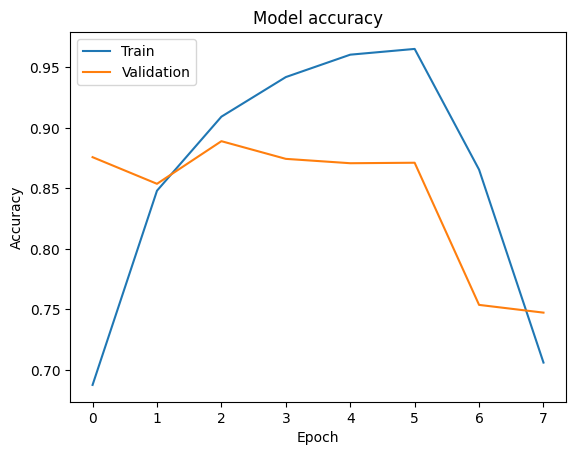

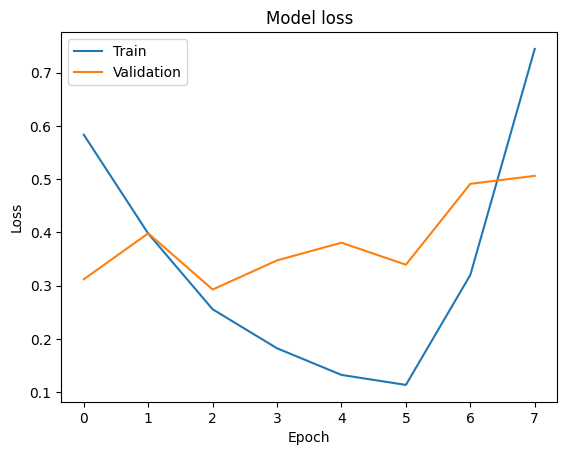

625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.9501 - loss: 0.1436
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8905 - loss: 0.2883
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 126ms/step - accuracy: 0.8694 - loss: 0.3495
Train acc: 0.952
Val acc: 0.889
Test acc: 0.867


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.97660,0.9048,0.88432,<built-in function max>,30.892226
1,bigram_MLP,"30000 tokens, None",0.082274,0.231371,0.250554,0.99115,0.9116,0.90196,<built-in function max>,41.305188
2,one_hot_bidir_lstm,"20000 tokens, None",0.140908,0.292924,0.354208,0.95225,0.8890,0.86732,<built-in function max>,2342.446983


In [ ]:
from keras import ops # Ensure ops is imported

rnn_units = 32
max_epochs = 10
model_name = "one_hot_bidir_lstm.keras"

###############################################
# Define the model architecture:
# Corrected: Input shape should reflect the fixed max_length
inputs = keras.Input(shape=(max_length,), dtype="int64") # Input shape is (None, max_length)

one_hot_encoded = layers.Lambda(lambda x: ops.one_hot(tf.cast(x, tf.int32), max_tokens), output_shape=(max_length, max_tokens))(inputs)

# The embedded tensor now has shape (None, max_length, max_tokens), which is 3D.
embedded = layers.Lambda(lambda x: ops.cast(x, "float32"))(one_hot_encoded)

# This 3D tensor is compatible with Bidirectional(LSTM).
x = layers.Bidirectional(layers.LSTM(rnn_units))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

- we can see a problem in training: the training error starts increasing after several epochs
- probable reason: exploding gradients problem
- we should add gradient clipping and regularization

### Apply the model to new data

In [ ]:
import keras
import tensorflow as tf

base_model = model

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

/usr/local/lib/python3.12/dist-packages/keras/src/backend/jax/core.py:88: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


text 0: 10.95 percent positive
text 1: 36.86 percent positive
text 2: 90.70 percent positive
text 3: 55.30 percent positive
text 4: 43.00 percent positive


## Sequential model that uses an Embedding layer trained from scratch
- __Embedding__ layer: https://keras.io/api/layers/core_layers/embedding/

`layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True)`

- we set `mask_zero=True` to let the model ignore padding positions during training  
  (padding tokens with index 0 are not included in the computation of LSTM/GRU states)
  - this usually improves performance on variable-length text sequences

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │  1,280,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     18,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,298,881 (4.95 MB)

 Trainable params: 1,298,881 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.6762 - loss: 0.5599 - val_accuracy: 0.8632 - val_loss: 0.3125
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 78ms/step - accuracy: 0.9076 - loss: 0.2288 - val_accuracy: 0.8776 - val_loss: 0.3017
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.9529 - loss: 0.1299 - val_accuracy: 0.8830 - val_loss: 0.3645
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.9717 - loss: 0.0780 - val_accuracy: 0.8832 - val_loss: 0.3802
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.9863 - loss: 0.0419 - val_accuracy: 0.8780 - val_loss: 0.4593
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9907 - loss: 0.0296 - val_accuracy: 0.8826 - val_loss: 0.4616
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9939 - loss: 0.0182 - val_accuracy: 0.8828 - val_loss: 0.5321
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


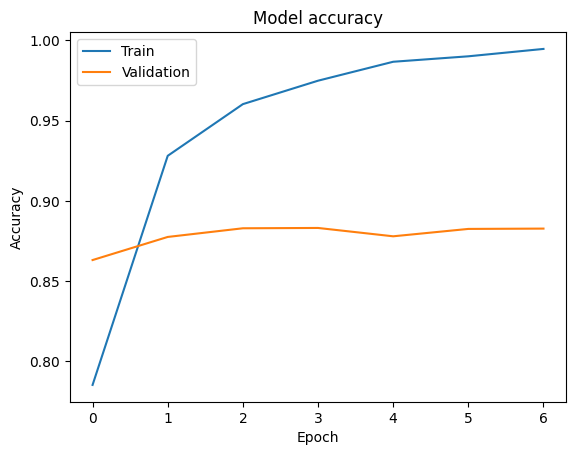

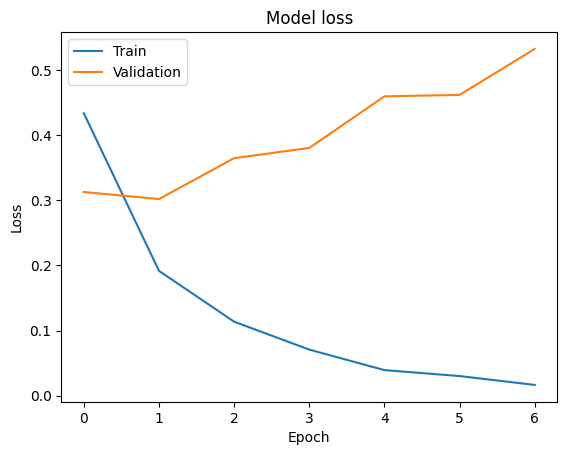

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9568 - loss: 0.1192
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8732 - loss: 0.3044
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8624 - loss: 0.3553
Train acc: 0.970
Val acc: 0.878
Test acc: 0.858


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.97660,0.9048,0.88432,<built-in function max>,30.892226
1,bigram_MLP,"30000 tokens, None",0.082274,0.231371,0.250554,0.99115,0.9116,0.90196,<built-in function max>,41.305188
2,one_hot_bidir_lstm,"20000 tokens, None",0.140908,0.292924,0.354208,0.95225,0.8890,0.86732,<built-in function max>,2342.446983
3,mbeddings_bidir_gru,"20000 tokens, None",0.093829,0.301724,0.359037,0.97025,0.8776,0.85784,<built-in function max>,347.972815


In [ ]:
rnn_units = 32
embedding_dim = 64 #256
max_epochs = 10
model_name = "embeddings_bidir_gru.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")

# Add an Embedding layer to convert integer tokens into dense vectors
embedded = layers.Embedding(
      input_dim=max_tokens,
      output_dim=embedding_dim,
      mask_zero=True
    )(inputs)
x = layers.Bidirectional(layers.GRU(rnn_units))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

__Observation:__
- the training is slow (in our case about 40 minutes on google colab CPU)
- the model overfitts early
- the results are worse than for the bigram+MLP approach: most probably because of the limit on sequence length (600 words)

### Apply the model to new data

In [ ]:
import keras
import tensorflow as tf

base_model = keras.models.load_model("models/embeddings_bidir_gru.keras")

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

/usr/local/lib/python3.12/dist-packages/keras/src/backend/jax/core.py:88: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


text 0: 4.74 percent positive
text 1: 56.58 percent positive
text 2: 99.47 percent positive
text 3: 78.02 percent positive
text 4: 58.04 percent positive


## Sequential model that uses existing pretrained word embeddings
- useful for small datasets

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-12-03 15:30:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-03 15:30:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-03 15:30:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Parse the GloVe word-embeddings file
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
# Prepare the GloVe word-embeddings matrix
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Embedding layer
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │  2,000,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     25,728 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,025,793 (7.73 MB)

 Trainable params: 25,793 (100.75 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - accuracy: 0.6072 - loss: 0.6511 - val_accuracy: 0.8248 - val_loss: 0.4048
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 70ms/step - accuracy: 0.8255 - loss: 0.3999 - val_accuracy: 0.8550 - val_loss: 0.3437
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8533 - loss: 0.3425 - val_accuracy: 0.8708 - val_loss: 0.3128
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8692 - loss: 0.3089 - val_accuracy: 0.8716 - val_loss: 0.3013
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8789 - loss: 0.2935 - val_accuracy: 0.8728 - val_loss: 0.2981
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8859 - loss: 0.2734 - val_accuracy: 0.8742 - val_loss: 0.3065
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8952 - loss: 0.2595 - val_accuracy: 0.8818 - val_loss: 0.2898
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9037 - loss: 0.2421 - 

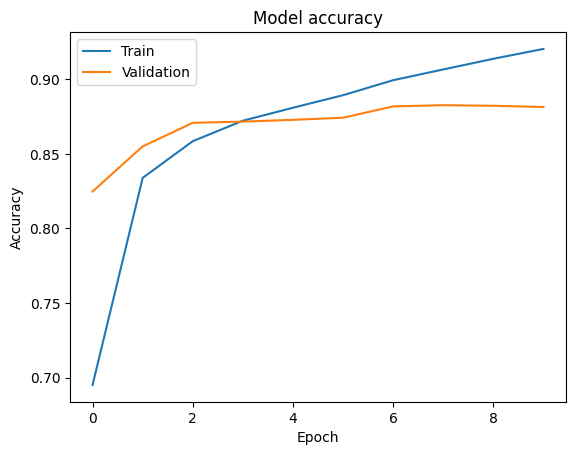

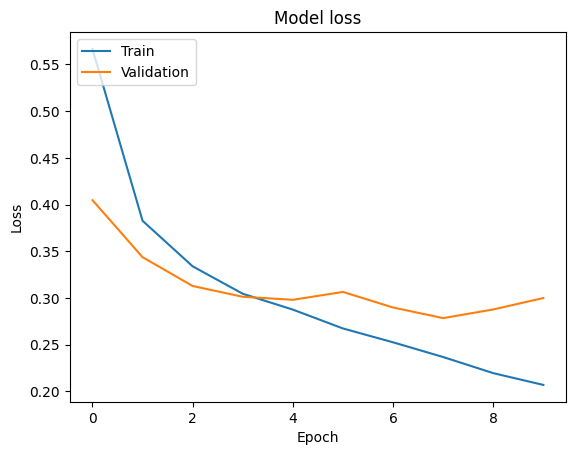

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9181 - loss: 0.2059
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8795 - loss: 0.2869
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8838 - loss: 0.2812
Train acc: 0.922
Val acc: 0.883
Test acc: 0.882


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.97660,0.9048,0.88432,<built-in function max>,30.892226
1,bigram_MLP,"30000 tokens, None",0.082274,0.231371,0.250554,0.99115,0.9116,0.90196,<built-in function max>,41.305188
2,one_hot_bidir_lstm,"20000 tokens, None",0.140908,0.292924,0.354208,0.95225,0.8890,0.86732,<built-in function max>,2342.446983
3,mbeddings_bidir_gru,"20000 tokens, None",0.093829,0.301724,0.359037,0.97025,0.8776,0.85784,<built-in function max>,347.972815
4,mbeddings_glove_gru,"20000 tokens, 32",0.198720,0.278463,0.281806,0.92220,0.8826,0.88180,<built-in function max>,450.876917


In [ ]:
hidden_dim = 32
embedding_dim = 64 #256
max_epochs = 10
model_name = "embeddings_glove_gru.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")

# Add an Embedding layer to convert integer tokens into dense vectors
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.GRU(hidden_dim))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

### Apply the model to new data

In [ ]:
import keras
import tensorflow as tf

base_model = model #keras.models.load_model("models/embeddings_glove_gru.keras")

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

/usr/local/lib/python3.12/dist-packages/keras/src/backend/jax/core.py:88: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


text 0: 14.34 percent positive
text 1: 61.36 percent positive
text 2: 99.52 percent positive
text 3: 71.20 percent positive
text 4: 51.45 percent positive


__Observations:__ worse results than training embedding from scratch for domain-specific sentences (e.g., last two)

## Sequential model that uses uses word embeddings pretrained by a CBOW model trained from scratch

In [ ]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int",
)

#### Preprocess the data for the CBOW model
- create windows of tokens from the training data, where each window consists of context words and a target word.
- The `window_data` function generates sliding windows of tokens, and `split_label`
 separates the context (bag) from the target (label) word within each window.
- The dataset is then mapped through a tokenizer, windowed, and split into (context, target) pairs.

In [ ]:
import tensorflow as tf

context_size = 4
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
dataset = dataset.map(split_label, num_parallel_calls=8)



Found 20000 files belonging to 2 classes.


### Train the CBOW  model

In [ ]:
hidden_dim = 64
inputs = keras.Input(shape=(2 * context_size,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
cbow_model = keras.Model(inputs, outputs)
cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

cbow_model.summary(line_length=80)

dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=4)



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)        │ (None, 8)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ embedding_2 (Embedding)           │ (None, 8, 64)            │     1,280,000 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling1d          │ (None, 64)               │             0 │
│ (GlobalAveragePooling1D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_6 (Dense)                   │ (None, 20000)            │     1,300,000 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 2,580,000 (9.84 MB)

 Trainable params: 2,580,000 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 157s 36ms/step - loss: 7.5874 - sparse_categorical_accuracy: 0.0348
Epoch 2/4


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 6.5190 - sparse_categorical_accuracy: 0.0365
Epoch 3/4
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 6.2092 - sparse_categorical_accuracy: 0.0397
Epoch 4/4
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 6.0034 - sparse_categorical_accuracy: 0.0998


#### Using the pretrained embedding for classification

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.5711 - loss: 0.6856 - val_accuracy: 0.7960 - val_loss: 0.4455
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.8153 - loss: 0.4201 - val_accuracy: 0.8660 - val_loss: 0.3173
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8967 - loss: 0.2670 - val_accuracy: 0.9016 - val_loss: 0.2727
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9284 - loss: 0.1938 - val_accuracy: 0.8720 - val_loss: 0.3663
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9552 - loss: 0.1295 - val_accuracy: 0.9084 - val_loss: 0.2905
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9756 - loss: 0.0764 - val_accuracy: 0.9050 - val_loss: 0.3572
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9869 - loss: 0.0462 - val_accuracy: 0.9056 - val_loss: 0.4135
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9918 - loss: 0.0280 - 

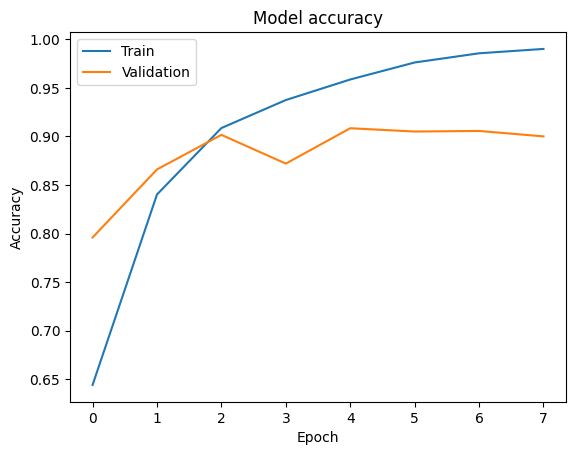

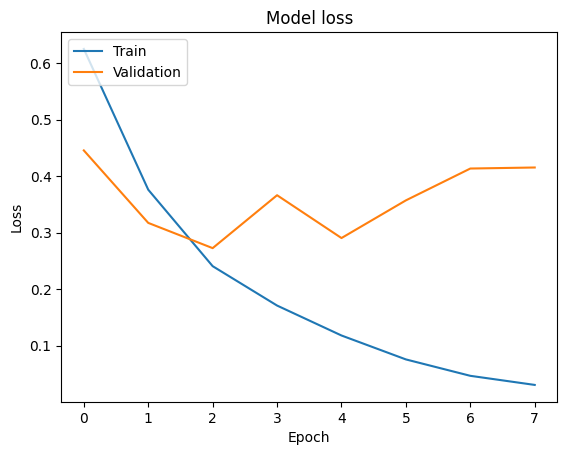

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9414 - loss: 0.1639
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8949 - loss: 0.2805
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8854 - loss: 0.3175
Train acc: 0.948
Val acc: 0.902
Test acc: 0.887


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.97660,0.9048,0.88432,<built-in function max>,30.892226
1,bigram_MLP,"30000 tokens, None",0.082274,0.231371,0.250554,0.99115,0.9116,0.90196,<built-in function max>,41.305188
2,one_hot_bidir_lstm,"20000 tokens, None",0.140908,0.292924,0.354208,0.95225,0.8890,0.86732,<built-in function max>,2342.446983
3,mbeddings_bidir_gru,"20000 tokens, None",0.093829,0.301724,0.359037,0.97025,0.8776,0.85784,<built-in function max>,347.972815
4,mbeddings_glove_gru,"20000 tokens, 32",0.198720,0.278463,0.281806,0.92220,0.8826,0.88180,<built-in function max>,450.876917
5,mbeddings_cbow_gru,"20000 tokens, 64",0.146965,0.272678,0.312200,0.94790,0.9016,0.88652,<built-in function max>,405.273072


In [ ]:
gru_dim = 32
embedding_dim = 64 #256
max_epochs = 10
model_name = "embeddings_cbow_gru.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.GRU(gru_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs, outputs, name="gru_with_cbow")

lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

In [ ]:
import pandas as pd
results_df = pd.read_csv("results.csv")
results_df

,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,BOW_MLP,"20000 tokens, None",0.114017,0.246925,0.284457,0.97660,0.9048,0.88432,<built-in function max>,30.892226
1,bigram_MLP,"30000 tokens, None",0.082274,0.231371,0.250554,0.99115,0.9116,0.90196,<built-in function max>,41.305188
2,one_hot_bidir_lstm,"20000 tokens, None",0.140908,0.292924,0.354208,0.95225,0.8890,0.86732,<built-in function max>,2342.446983
3,mbeddings_bidir_gru,"20000 tokens, None",0.093829,0.301724,0.359037,0.97025,0.8776,0.85784,<built-in function max>,347.972815
4,mbeddings_glove_gru,"20000 tokens, 32",0.198720,0.278463,0.281806,0.92220,0.8826,0.88180,<built-in function max>,450.876917
5,mbeddings_cbow_gru,"20000 tokens, 64",0.146965,0.272678,0.312200,0.94790,0.9016,0.88652,<built-in function max>,405.273072


In [ ]:
import keras
import tensorflow as tf

base_model = model # keras.models.load_model("models/embeddings_cbow_gru.keras")

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

text 0: 2.68 percent positive
text 1: 42.95 percent positive
text 2: 99.64 percent positive
text 3: 89.49 percent positive
text 4: 73.13 percent positive


## Simple Transformer model trained from scratch on word embedding

In [9]:
import tensorflow as tf
import keras
from keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Define and train the Transformer model

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 256)      │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, None, 256)      │       543,776 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,664,033 (21.61 MB)

 Trainable params: 5,664,033 (21.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.6331 - loss: 0.7178 - val_accuracy: 0.8426 - val_loss: 0.3461
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8707 - loss: 0.3038 - val_accuracy: 0.8864 - val_loss: 0.2891
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9399 - loss: 0.1585 - val_accuracy: 0.8740 - val_loss: 0.3859
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9691 - loss: 0.0810 - val_accuracy: 0.8670 - val_loss: 0.4937
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.9837 - loss: 0.0464 - val_accuracy: 0.8666 - val_loss: 0.6193
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9888 - loss: 0.0300 - val_accuracy: 0.8690 - val_loss: 0.6782
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.9893 - loss: 0.0302 - val_accuracy: 0.8664 - val_loss: 0.7248
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


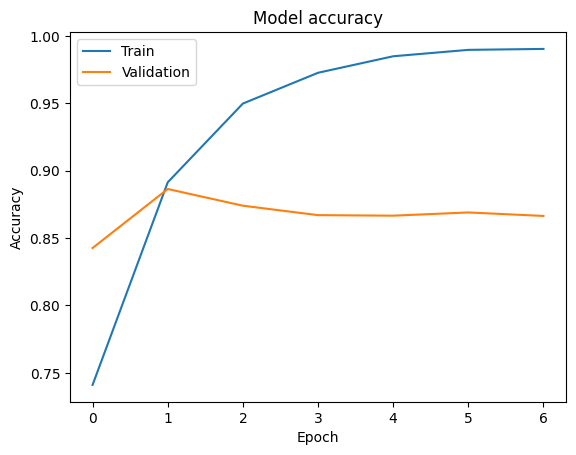

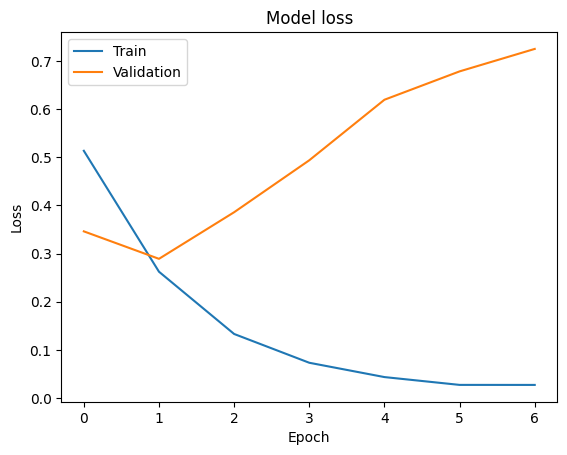

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9503 - loss: 0.1328
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8870 - loss: 0.2896
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8731 - loss: 0.3172
Train acc: 0.965
Val acc: 0.886
Test acc: 0.872


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,imple_transform,,0.100951,0.289118,0.315976,0.96495,0.8864,0.87176,<built-in function max>,247.964313


In [18]:
# max_tokens = 20000
# max_length = 600

max_epochs = 20
embedding_dim = 256
num_heads = 2
dense_dim = 32

model_name = "simple_transformer.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_tokens, embedding_dim)(inputs)
x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", #"rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : "",
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

#### Apply the model to new data

In [19]:
import keras
import tensorflow as tf

base_model = model

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

text 0: 1.96 percent positive
text 1: 74.11 percent positive
text 2: 99.14 percent positive
text 3: 97.52 percent positive
text 4: 75.60 percent positive


## Simple Transformer model trained from scratch on positional embedding

In [20]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim, mask_zero=True) ## added
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    '''
    def compute_mask(self, inputs, mask=None):
        #return None
        return tf.not_equal(inputs, 0)
        #return tf.cast(inputs != 0, dtype=tf.bool)
        #return tf.math.not_equal(inputs, 0)
        # Updated: Use TensorFlow compatible boolean mask creation
        mask_layer = layers.Lambda(lambda x: tf.cast(x != 0, dtype=tf.bool))
        return mask_layer(inputs)
    '''
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_1          │ (None, None, 64)       │     1,318,400 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_6           │ (None, None, 64)       │        37,664 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,356,129 (5.17 MB)

 Trainable params: 1,356,129 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.6031 - loss: 0.7037 - val_accuracy: 0.8834 - val_loss: 0.2891
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9043 - loss: 0.2428 - val_accuracy: 0.8832 - val_loss: 0.3186
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9507 - loss: 0.1426 - val_accuracy: 0.8838 - val_loss: 0.4443
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9731 - loss: 0.0875 - val_accuracy: 0.8710 - val_loss: 0.5902
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9840 - loss: 0.0532 - val_accuracy: 0.8716 - val_loss: 0.5976
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9875 - loss: 0.0421 - val_accuracy: 0.8712 - val_loss: 0.5935
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


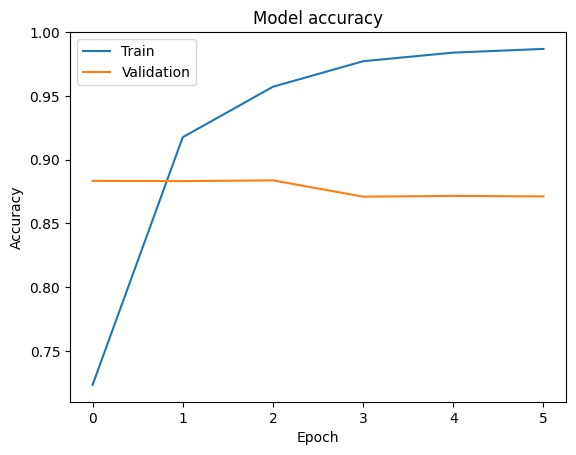

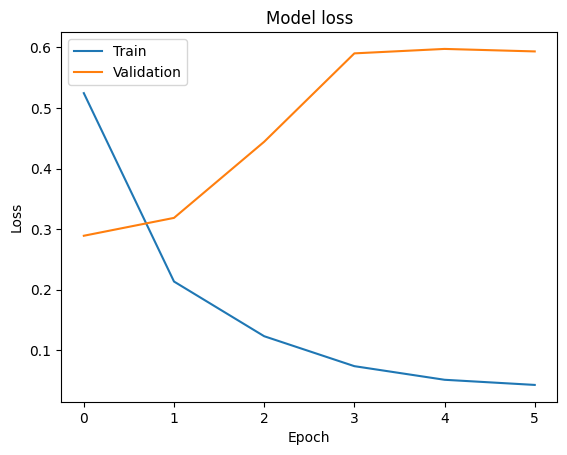

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9037 - loss: 0.2423
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8799 - loss: 0.2901
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8789 - loss: 0.2900
Train acc: 0.920
Val acc: 0.883
Test acc: 0.880


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,imple_transform,,0.100951,0.289118,0.315976,0.96495,0.8864,0.87176,<built-in function max>,247.964313
1,imple_transformer_positional,,0.208923,0.289108,0.290035,0.92050,0.8834,0.87980,<built-in function max>,89.724519


In [23]:
# max_tokens = 20000
# max_length = 600

max_epochs = 20
embedding_dim = 64 #256
num_heads = 2
dense_dim = 32

model_name = "simple_transformer_positional.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(max_length, max_tokens, embedding_dim)(inputs)  # CHANGE HERE
x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",    #"rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : "",
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

#### Apply the model to new data

In [24]:
import keras
import tensorflow as tf

base_model = model

raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)

# Vectorize the raw text data using the adapted TextVectorization layer
processed_raw_text_data = text_vectorization(raw_text_data)

# Make predictions using the base model with the vectorized numerical input
predictions = base_model(processed_raw_text_data)

for i in range(len(raw_text_data)):
    # Access the scalar value by indexing predictions[i] with [0]
    print(f"text {i}: {float(predictions[i][0] * 100):.2f} percent positive")

text 0: 0.23 percent positive
text 1: 94.40 percent positive
text 2: 99.94 percent positive
text 3: 92.22 percent positive
text 4: 65.07 percent positive


## Finetuning a Pretrained Transformer
- RoBERTa model: trained on 160 GB english language web text

In [1]:
## Loading a pretrained Transformer
# and the corresponding tokenizer

import keras_hub

tokenizer = keras_hub.models.Tokenizer.from_preset("roberta_base_en")
backbone = keras_hub.models.Backbone.from_preset("roberta_base_en")

print(tokenizer("The quick brown fox"))
backbone.summary(line_length=80)

tf.Tensor([  133  2119  6219 23602], shape=(4,), dtype=int32)


Model: "roberta_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ token_ids             │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embeddings            │ (None, None, 768) │  38,996,736 │ token_ids[0][0]    │
│ (TokenAndPositionEmb… │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embeddings_layer_norm │ (None, None, 768) │       1,536 │ embeddings[0][0]   │
│ (LayerNormalization)  │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embeddings_dropout    │ (None, None, 768) │           0 │ embeddings_layer_… │
│ (Dropout)             │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ padding_mask          │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_0   │ (None, None, 768) │   7,087,872 │ embeddings_dropou… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_1   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_2   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_3   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_4   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_5   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_6   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_7   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_8   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_9   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_10  │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │      

 Total params: 124,052,736 (473.22 MB)

 Trainable params: 124,052,736 (473.22 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Load and process the data
from keras.utils import text_dataset_from_directory

batch_size = 16
train_dir = "aclImdb/train"
val_dir = "aclImdb/val"
test_dir = "aclImdb/test"

train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [11]:
# Preprocess the data - the tokenizer needs a special shape
def preprocess(text, label):
    packer = keras_hub.layers.StartEndPacker(
        sequence_length=512,
        start_value=tokenizer.start_token_id,
        end_value=tokenizer.end_token_id,
        pad_value=tokenizer.pad_token_id,
        return_padding_mask=True,
    )
    token_ids, padding_mask = packer(tokenizer(text))
    return {"token_ids": token_ids, "padding_mask": padding_mask}, label

preprocessed_train_ds = train_ds.map(preprocess)
preprocessed_val_ds = val_ds.map(preprocess)
preprocessed_test_ds = test_ds.map(preprocess)

next(iter(preprocessed_train_ds))

({'token_ids': <tf.Tensor: shape=(16, 512), dtype=int32, numpy=
  array([[    0,  8346,     6, ..., 31712,    39,     2],
         [    0,   713,  1569, ...,     1,     1,     1],
         [    0, 38544,   274, ...,     1,     1,     1],
         ...,
         [    0,   250,  6967, ...,     1,     1,     1],
         [    0,  3750,   498, ...,    79,    16,     2],
         [    0,   100,   109, ...,     1,     1,     1]], dtype=int32)>,
  'padding_mask': <tf.Tensor: shape=(16, 512), dtype=bool, numpy=
  array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ..., False, False, False]])>},
 <tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int32)>)

In [ ]:
# max_tokens = 20000
# max_length = 600

max_epochs = 1    # finetuning
model_name = "pretrained_transformer.keras"

###############################################
# Define the model architecture:
from keras import layers
inputs = backbone.input
x = backbone(inputs)
x = x[:, 0, :] # use the hidden representation of the first token
x = layers.Dropout(0.1)(x)
x = layers.Dense(768, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(preprocessed_train_ds,
          validation_data=preprocessed_val_ds,
          epochs=max_epochs) #callbacks=callbacks)

time_fit = time.time() - start_time

###############################
# Plot the training progress:
#plot_history(history)

train_loss, train_acc = model.evaluate(preprocessed_train_ds)
val_loss, val_acc = model.evaluate(preprocessed_val_ds)
test_loss, test_acc = model.evaluate(preprocessed_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name.strip(".keras"),
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max_epochs,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

In [22]:
results_df

,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,pretrained_transform,,0.112553,0.16857,0.155052,0.9624,0.939,0.94072,1,2091.480211


## To be done
- comments
- new code for Transformer
- finish and run the pretrained transformer part